In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import vit_l_16, ViT_L_16_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

torch.set_float32_matmul_precision("medium")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [3]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, stratify=img_labels['label'])

display(train_df.head())

training_data = GlobalStreetscapesSample(
    train_df
)

test_data = GlobalStreetscapesSample(
    test_df
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

samples rows: 190693
paths rows: 200660
img_labels rows: 190693


,uuid,source,orig_id,city,country,iso3,lat,lon,s2_cell_id,label,path
118485,35922f85-53c7-4c2f-910e-b8b9a722211a,Mapillary,881543469110747,Washington,United States,USA,38.907183,-77.025633,9923602531395567616,41,../data/imgs/1abbabf7-f30d-4a6c-a9a3-3ebe615b6...
27768,9f968f15-10ab-4dd9-88c7-2df9041796e4,Mapillary,400675382205853,Washington,United States,USA,38.896719,-77.029559,9923602163370557440,90,../data/imgs/58a77211-c162-409c-890f-c1fd70396...
59371,a92be1cb-7ff4-4915-b2b7-255c1316318f,Mapillary,1057000915050867,Washington,United States,USA,38.895396,-77.031942,9923602168470831104,4,../data/imgs/25a1b41f-d36e-489e-831b-5538b6042...
72245,6c26cfbc-43a8-476e-b1f1-a8cb4001085c,Mapillary,1068497847384816,Washington,United States,USA,38.905636,-77.029712,9923602524953116672,122,../data/imgs/b0966b4d-b376-46a9-a07a-b68205d40...
128350,263ac71e-46dd-4607-822c-58bb4ffa5252,Mapillary,194098883040098,Washington,United States,USA,38.892158,-77.028331,9923602173571104768,128,../data/imgs/3be09e17-e9b2-4c56-8692-4dd09a509...


Washington


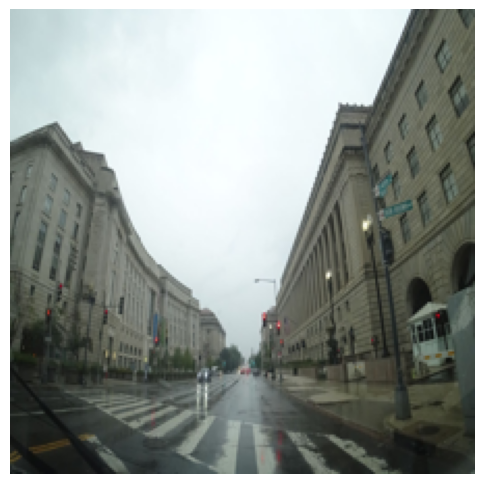

In [4]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_l_16.html
weights = ViT_L_16_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_l_16(weights=weights)

in_features = model.heads.head.in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.heads.head}")
model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)
model.num_classes = num_classes
print(f"Previous head: {model.heads.head}")
print(f"Number of classes: {model.num_classes}")

#model = model.to(device=device)
#print(f"Using device: {device}")

Previous head: Linear(in_features=1024, out_features=1000, bias=True)
Previous head: Linear(in_features=1024, out_features=144, bias=True)
Number of classes: 144


In [6]:
model = model.to(device=device)
model = torch.compile(model)
print(f"Using device: {device}")

Using device: cuda


In [7]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Changed to OneCycleLR with 10% warmup
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)
train_loss_list = []
avg_train_loss_list = []
train_loss = 0
for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step() # Moved inside the batch loop for OneCycleLR
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_loss += avg_train_loss
    print(f"Loss: {avg_train_loss:.3f} ({train_loss / (epoch+1):.3f})")
    train_loss_list.append(avg_train_loss)
    avg_train_loss_list.append(train_loss / (epoch+1))
    # Print current LR to verify schedule
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    torch.save(model.state_dict(), f'vit_b_16_base_epoch{epoch}.pth')

EPOCH: 1


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 2.963 (2.963)
LR: 0.000052
EPOCH: 2


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.804 (2.384)
LR: 0.000100
EPOCH: 3


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.459 (2.076)
LR: 0.000099
EPOCH: 4


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.250 (1.869)
LR: 0.000097
EPOCH: 5


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.126 (1.721)
LR: 0.000093
EPOCH: 6


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.045 (1.608)
LR: 0.000088
EPOCH: 7


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.993 (1.520)
LR: 0.000082
EPOCH: 8


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.953 (1.449)
LR: 0.000075
EPOCH: 9


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.925 (1.391)
LR: 0.000067
EPOCH: 10


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.899 (1.342)
LR: 0.000059
EPOCH: 11


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.876 (1.299)
LR: 0.000050
EPOCH: 12


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.859 (1.263)
LR: 0.000041
EPOCH: 13


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.845 (1.231)
LR: 0.000033
EPOCH: 14


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.834 (1.202)
LR: 0.000025
EPOCH: 15


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.826 (1.177)
LR: 0.000018
EPOCH: 16


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.821 (1.155)
LR: 0.000012
EPOCH: 17


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.819 (1.135)
LR: 0.000007
EPOCH: 18


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.818 (1.118)
LR: 0.000003
EPOCH: 19


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.817 (1.102)
LR: 0.000001
EPOCH: 20


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.817 (1.087)
LR: 0.000000


In [8]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 1.501
Test Accuracy: 84.09%
